In [25]:
from datetime import datetime

from pathlib import Path

import numpy as np
from scipy.stats import lognorm
import pandas as pd

from astropy import stats
import astropy.units as u
from astropy.io import fits
from astropy.visualization import hist

from matplotlib import style
style.use("seaborn")
style.use('ggplot')
import matplotlib.pyplot as plt

%load_ext autoreload
%autoreload 2
#%matplotlib widget

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
rootdir = Path("/mnt/f/wfsdat")
# use find to make this csv list
with open(rootdir / "reanalyze_csvs_2022_q2.txt") as f:
    csvs = f.readlines()

# loop through the csv files and read them with pandas
frames = []
for csv in csvs:
    frames.append(pd.read_csv(rootdir / csv.rstrip()))

# now concat each frame into one big frame containing all of the data
data = pd.concat(frames)

In [3]:
g = data.groupby('wfs')
g.wfs.describe()

,count,unique,top,freq
wfs,,,,
binospec,6857,1,binospec,6857
f5,830,1,f5,830
mmirs,572,1,mmirs,572
newf9,212,1,newf9,212


In [4]:
# re-calculate the seeing using updated spot FWHM for binospec. filter out any NaN values...
#fixed_list = []
#for wfskey, group in g:
#    wfs = wfs_systems[wfskey]
#    group = g.get_group(wfskey)
#    #group.apply(seeing, axis=1, args=(wfs,))
#    group['fixed_raw_seeing'], group['fixed_seeing'] = seeing(group, wfs)
#    fixed_list.append(group)
#fixed = pd.concat(fixed_list)
#fixed.rename(index=str, columns={"seeing": "orig_seeing", "raw seeing": "orig_raw_seeing"}, inplace=True)
#fixed.rename(index=str, columns={"fixed_seeing": "seeing", "fixed_raw_seeing": "raw seeing"}, inplace=True)
fixed = data[np.isfinite(data['seeing'])]
fixed = fixed[fixed['fwhm'] > 0.]
fixed = fixed[fixed['seeing'] > 0.]
fixed = fixed[fixed['seeing'] < 4.]
#fixed = fixed[fixed['time'] < "2020-12-31"]

In [5]:
fixed.sort_values(by='time')

,time,wfs,file,exptime,airmass,az,el,osst,outt,chamt,...,focerr,cc_x_err,cc_y_err,xcen,ycen,seeing,raw_seeing,fwhm,wavefront_rms,residual_rms
0,2022-04-01T04:20:19.471000,binospec,wfs_ff_cal_img_2022.0401.042019.fits,35.0,1.2113,36.556180,55.644399,5.8,5.3,5.731,...,95.48,-0.000,-5.688,257.003328,250.992521,1.310701,1.470464,7.070132,2362.923095,1740.536589
1,2022-04-01T04:20:57.767000,binospec,wfs_ff_cal_img_2022.0401.042057.fits,35.0,1.2101,36.472613,55.731646,5.8,5.3,5.706,...,62.10,-4.907,-0.000,256.997688,251.009014,1.290841,1.447323,6.981962,1586.421151,1677.561788
2,2022-04-01T04:21:35.950000,binospec,wfs_ff_cal_img_2022.0401.042135.fits,35.0,1.2090,36.400944,55.805546,5.8,5.2,5.700,...,21.96,-5.076,0.000,257.003520,249.990270,1.281172,1.435699,6.937609,693.206037,1689.388408
3,2022-04-01T04:22:14.118000,binospec,wfs_ff_cal_img_2022.0401.042214.fits,35.0,1.2078,36.316573,55.891892,5.8,5.2,5.704,...,12.77,-2.347,1.745,257.503388,257.509601,1.153162,1.291479,6.383563,485.128927,1888.367059
4,2022-04-01T04:22:52.312000,binospec,wfs_ff_cal_img_2022.0401.042252.fits,35.0,1.2067,36.242941,55.966414,5.8,5.3,5.704,...,8.01,0.000,0.849,258.003581,258.513362,1.236565,1.384129,6.740296,381.211082,1875.250932
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1,2022-06-23T08:04:02.914000,f5,f5wfs_20220623-010435.fits,30.0,1.4426,189.483932,43.882741,17.0,15.2,16.461,...,12.60,0.754,-0.125,248.999245,265.004357,1.522649,1.897088,10.299734,439.772679,1534.699924
2,2022-06-23T08:04:40.136000,f5,f5wfs_20220623-010512.fits,30.0,1.4431,189.680420,43.862624,17.0,15.2,16.492,...,10.50,0.000,0.116,251.991704,264.008047,1.160155,1.445752,8.306116,343.276099,1418.612068
3,2022-06-23T08:05:43.820000,f5,f5wfs_20220623-010616.fits,30.0,1.4441,190.039343,43.824655,17.0,15.2,16.513,...,6.77,0.000,-0.000,250.996846,264.003591,1.223723,1.525603,8.663853,274.681395,1454.631891
4,2022-06-23T10:19:59.621000,f5,f5wfs_20220623-032031.fits,30.0,1.1487,159.856113,60.525611,16.0,14.9,15.491,...,1.81,-6.511,-1.961,260.000382,267.001779,1.601383,1.740281,9.614716,446.015247,1464.205423


In [6]:
# create a date-time index so we can group and analyze the data by timestamps
fixed = fixed.set_index(pd.DatetimeIndex(fixed['time'], name='ut'))

<Figure size 576x360 with 0 Axes>

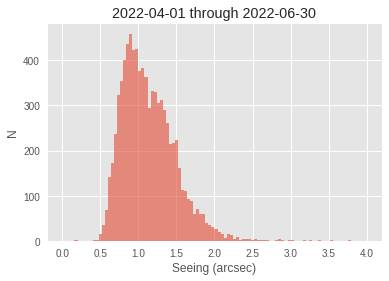

In [7]:
# make raw histogram of the zenith-corrected seeing column
fig = plt.figure(figsize=(8, 5))
fixed.hist(column='seeing', bins=100, range=(0.0, 4.0), alpha=0.6)
with plt.style.context('ggplot'):
    plt.title("2022-04-01 through 2022-06-30")
    plt.xlabel("Seeing (arcsec)")
    plt.ylabel("N")
plt.show()

In [8]:
# fit a log-normal distribution to the seeing data
sigma, loc, exp_mu = lognorm.fit(fixed['seeing'])
print(sigma, loc, exp_mu)
x = np.arange(0.0, 4.0, 0.01)
p = lognorm.pdf(x, sigma, loc=loc, scale=exp_mu)
mu = np.log(exp_mu)
mode = np.exp(mu - sigma**2) + loc
median = np.nanmedian(fixed['seeing'])
fit_median = exp_mu + loc

0.3235663783867018 0.09021762997899967 0.9893476235306085


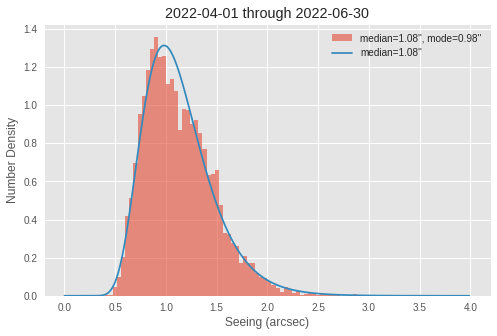

In [9]:
# plot normalized histogram with the fit and the median/mode calculated from the fit.
fig = plt.figure(figsize=(8, 5))
with plt.style.context('ggplot'):
    plt.hist(fixed['seeing'], density=True, bins=100, range=(0.0, 4.0), label="hist", alpha=0.6)
    logp = plt.plot(x, p, label="logp")
    plt.xlabel("Seeing (arcsec)")
    plt.ylabel("Number Density")
    plt.title("2022-04-01 through 2022-06-30")
    plt.legend(["median=%.2f\", mode=%.2f\"" % (fit_median, mode), "median=%.2f\"" % (
        median
    )])
    plt.savefig("2022q2_hist.png")
plt.show()

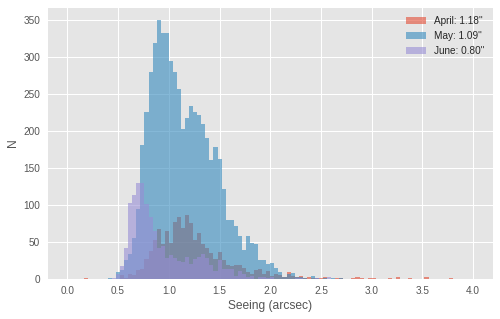

In [10]:
# panda time indexing makes it easy to group by month
fig = plt.figure(figsize=(8, 5))
months = {}
legends = []
months['April'] = fixed.loc['2022-04']
months['May'] = fixed.loc['2022-05']
months['June'] = fixed.loc['2022-06']
for m in months:
    plt.hist(months[m]['seeing'], bins=100, range=(0.0, 4.0), label=m, alpha=0.6)
    legend = "%s: %.2f\"" % (m, np.median(months[m]['seeing']))
    legends.append(legend)
plt.legend(legends)
plt.xlabel("Seeing (arcsec)")
plt.ylabel("N")
#plt.title("Data and median seeing values grouped by month")
plt.savefig("2022q2_monthly.png")
plt.show()

In [11]:
# now use the between_time() method to split the data into first and second halves of the night.
first_half = fixed.between_time(start_time='00:00', end_time='07:00')
second_half = fixed.between_time(start_time='07:00', end_time='14:00')
#first_half = months['December'].between_time(start_time='00:00', end_time='07:00')
#second_half = months['December'].between_time(start_time='07:00', end_time='14:00')
med_1st = np.median(first_half['seeing'])
med_2nd = np.median(second_half['seeing'])

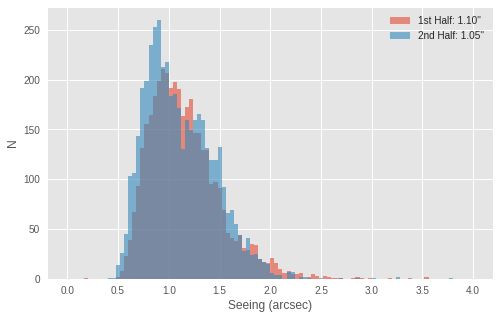

In [12]:
# plot the results and show that the seeing is better later in the night...
fig = plt.figure(figsize=(8, 5))
plt.hist(first_half['seeing'], bins=100, range=(0.0, 4.0), label="1st", alpha=0.6)
plt.hist(second_half['seeing'], bins=100, range=(0.0, 4.0), label="2nd", alpha=0.6)
plt.legend(["1st Half: %.2f\"" % med_1st, "2nd Half: %.2f\"" % med_2nd])
plt.xlabel("Seeing (arcsec)")
plt.ylabel("N")
#plt.title("Data and median seeing values grouped by half of the night")
plt.savefig("2022q2_1st2nd.png")
plt.show()

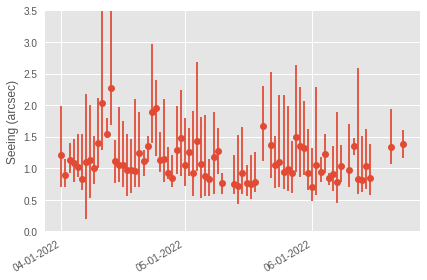

In [17]:
import matplotlib.dates as mdates

# make a new data frame that resamples the WFS data daily into the median, min, and max seeing for each day.
#fixed = fixed["2018-06-30":"2018-10-01"]
fig, ax = plt.subplots()
daily = pd.DataFrame()
daily['seeing'] = fixed.seeing.resample('D').median()
daily['max'] = fixed.seeing.resample('D').max()
daily['min'] = fixed.seeing.resample('D').min()
lowb = daily['seeing'] - daily['min']
upb = daily['max'] - daily['seeing']
plt.errorbar(daily.index, daily['seeing'], yerr=[lowb, upb], fmt='o')
ax.xaxis.set_major_locator(mdates.MonthLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter("%m-%d-%Y"))
ax.set_ylim(0.0, 3.5)
fig.autofmt_xdate()
plt.tight_layout()
plt.ylabel("Seeing (arcsec)")
#plt.title("Nightly median seeing")
plt.savefig("2022q2_nightly.png")
plt.show()

In [18]:
date_list = list(daily.index.strftime('%Y-%m-%d'))
data = [np.array(fixed.loc[date]['seeing']) for date in date_list]
clean_data = {}
for d, arr in zip(date_list, data):
    if len(arr) > 0:
        clean_data[d] = arr
date_labels = [datetime.strptime(d, "%Y-%m-%d").date() for d in clean_data.keys()]

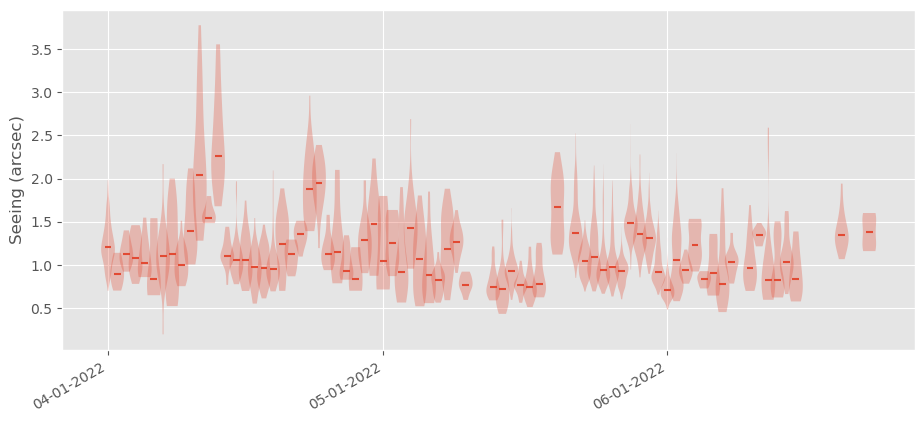

In [19]:
with plt.style.context('ggplot', after_reset=True):
    fig, ax = plt.subplots(figsize=(11,5))
    plt.violinplot(clean_data.values(), mdates.date2num(date_labels), points=50, widths=1.5,
                showextrema=False, showmedians=True, bw_method='silverman')

    ax.xaxis.set_major_locator(mdates.MonthLocator())
    ax.xaxis.set_major_formatter(mdates.DateFormatter("%m-%d-%Y"))
    fig.autofmt_xdate()
    plt.ylabel("Seeing (arcsec)")
    plt.savefig("2022q2_violin.png")
    plt.show()

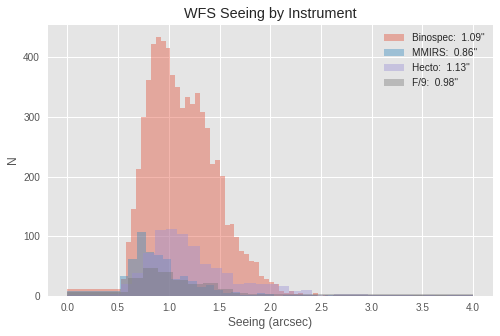

In [30]:
with plt.style.context('ggplot'):
    fig = plt.figure(figsize=(8, 5))
    medb = np.median(fixed['seeing'][fixed['wfs'] == 'binospec'])
    medm = np.median(fixed['seeing'][fixed['wfs'] == 'mmirs'])
    medf = np.median(fixed['seeing'][fixed['wfs'] == 'f5'])
    med9 = np.median(fixed['seeing'][fixed['wfs'] == 'newf9'])
    hist(fixed['seeing'][fixed['wfs'] == 'binospec'], bins='freedman', density=False, range=(0.0, 4.), alpha=0.4, label=f"Binospec: {medb: .2f}\"")
    hist(fixed['seeing'][fixed['wfs'] == 'mmirs'], bins='freedman', density=False, range=(0.0, 4.), alpha=0.4, label=f"MMIRS: {medm: .2f}\"")
    hist(fixed['seeing'][fixed['wfs'] == 'f5'], bins='freedman', density=False, range=(0.0, 4.), alpha=0.4, label=f"Hecto: {medf: .2f}\"")
    hist(fixed['seeing'][fixed['wfs'] == 'newf9'], bins='freedman', density=False, range=(0.0, 4.), alpha=0.4, label=f"F/9: {med9: .2f}\"")
    plt.legend()
    plt.title("WFS Seeing by Instrument")
    plt.xlabel("Seeing (arcsec)")
    plt.ylabel("N")
plt.savefig("per_instrument_2022q2.png")
plt.show()

In [18]:
mmirs = fixed[fixed['wfs'] == 'mmirs']